# Introduction to RL

This notebook is my playing around with Reinforcement learning models. It can be thought of as a `hello world` notebook to setup Cuda, CuDNN, aigym etc. I plan to solve a couple of aigym problems using various techniques.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gym import wrappers, envs
import time

## CartPole-v0

The cartpole problem is typically the first problem analysed in RL. It consists of an inverted pendulum on a 1d slide. The aim is to keep the pendulum vertical by moving the cart either left or right in reponse to it falling over. The game ends when the pole's lean exceeds 15 degrees or the slide moves out of the playing area. Below I have implemented a number of techniques for solving this problem in order of increasing complexity.

The state space looks like `cart position, cart velocity, pole angle, pole velocity at tip`.

The action space looks like `move left, move right`.

AiGym keep excellent documentation on each of their environments on their [github page](https://github.com/openai/gym/wiki/CartPole-v0)

### Dumb Solution with Random actions

We are going to run our simulation to completion taking random actions each step.

In [2]:
# Initialise
env = gym.make('CartPole-v0')
TotalReward=0
done=False
observation=env.reset()
# Loop until the pole falls.
while not done:
    # Render the environment to screen.
    env.render()
    # Pause such that this loop creates a 10Hz movie of the system.
    time.sleep(0.1)
    # Choose a random action
    action=env.action_space.sample()
    # Enact the chosen action
    observation, reward, done, info = env.step(action)
    TotalReward+=reward
    if done:
        break
    
print("Reward was: ",TotalReward)
env.close()

Reward was:  18.0


In [18]:
help(env)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min             Max
 |      0       Cart Position             -4.8            4.8
 |      1       Cart Velocity             -Inf            Inf
 |      2       Pole Angle                -24 deg         24 deg
 |      3       Pole Velocity At Tip      -Inf            Inf
 |  
 |  Actions:
 |      Type: Discrete(2)
 |      Num     Action
 |      0       Push cart to the left
 |      1       Push ca

### Monte Carlo Style Solution

Next we are going to create a vector with random numbers and take the dot product of this random vector with the present state. We are then going to take an action depending on the sign of this dot product. I am not too sure why this works, but it does seem to do a good job.

We will then search for the random vector that gives the highest reward.

best length is 82.49
best length is 82.49
best length is 123.3
best length is 195.61
best length is 195.61
best length is 195.61
best length is 195.61
best length is 200.0
best length is 200.0
best length is 200.0
Game with best weights ran for  200.0  turns


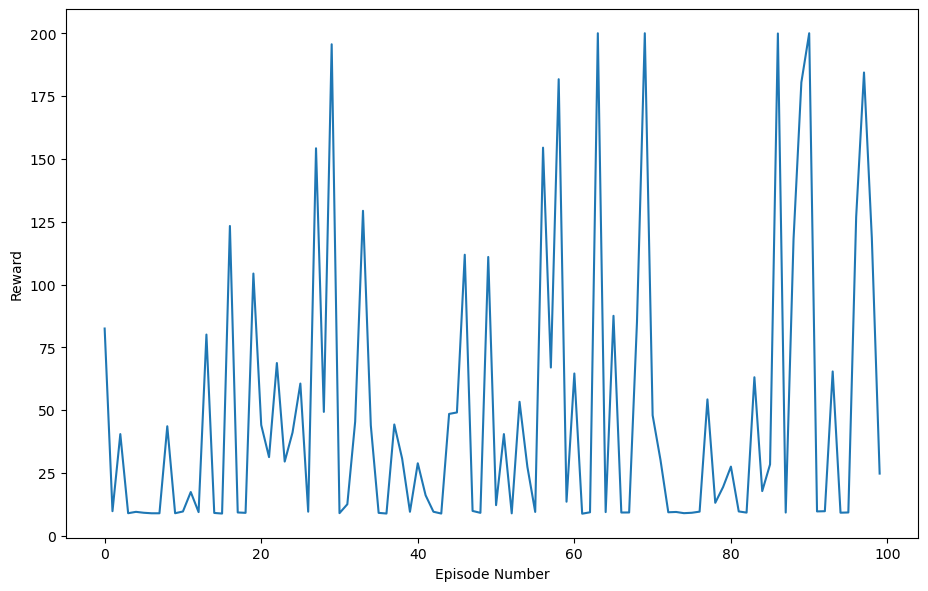

In [4]:
env = gym.make('CartPole-v0')
bestLength=0
episode_lengths=[]

best_weights=np.zeros(4)
# Loop over 100 random vectors.
for i in range(100):
    new_weights= np.random.uniform(-1.0,1.0,4)

    # try this vector 100 times to give an average reward.
    # store the reward of each trial in the list length
    length=[]
    for j in range(100):
        done=False
        observation = env.reset()
        TotalReward=0
        
        while not done:
            
            # Take dot products of new_weights with observations
            # result = +ve move right
            #        = -ve move left
            action = 1 if np.dot(new_weights,observation) > 0 else 0
            observation, reward, done, info = env.step(action)
            TotalReward+=reward
            if done:
                break
        length.append(TotalReward)
    # Calc. the average reward    
    average_length=float(sum(length)/len(length))
    # If these weights are better, keep them.
    if average_length > bestLength:
        bestLength = average_length
        best_weights = new_weights
    episode_lengths.append(average_length)
    if i % 10 == 0 :
        print('best length is', bestLength)

# Plot the reward history.
fig=plt.figure(figsize=(11,7), dpi=100)
plt.plot(episode_lengths)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
        
# Show the best weights in action
done=False
TotalReward=0
observation=env.reset()
while not done:
    # Show movie @ 50Hz.
    env.render()
    time.sleep(0.02)
    action = 1 if np.dot(best_weights, observation) > 0 else 0
    observation, reward, done, info = env.step(action)
    TotalReward+=reward
    if done:
        break
        
env.close()        
print("Game with best weights ran for ",TotalReward, " turns")

### Deep learning Solution

This is from the pytorch documentation on reinforcement learning. I am currently working my way through it.

This involves a slightly more complicated RL solution that I would like at this stage: it extracts the state space directly from diffences in adjacent rendered images using a convolutional neural net. I would prefer at this point to use the state space information directly from the calls to `env.step` instead as this would be much easier to understand. 

In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cuda for simulation.


In [6]:
# Named tuples are like tuples but add this feature:
#  print(Transition.state) = print(Transition[0])
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [7]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        print("Input Size: ", linear_input_size)
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [19]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
env.close()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

<Figure size 432x288 with 0 Axes>

In [20]:
BATCH_SIZE = 2048
# Discount Factor
GAMMA = 0.999

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())



RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [22]:
num_episodes = 5
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

## Acrobot-v1

Acrobot is a slightly more complex simulation.

In [ ]:
done=False
observation = env.reset()
cnt=0
total_reward=0
        
while not done:
    cnt+=1
    time.sleep(0.02)
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    total_reward+=reward
    if cnt % 10 ==0:
        print("reward on step ",cnt," is ", total_reward)
        print("observation is ", observation)
    if done:
        break
    
env.close()

In [ ]:
torch.cuda.is_available()